In [1]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import RobustScaler
from scipy.interpolate import UnivariateSpline
from xgboost.sklearn import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from statsmodels.api import OLS
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [2]:
def load_data(train_path, test_path):
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    return train_data, test_data

In [3]:
def visualize_data(data, features):
    for feature in features:
        plt.figure(figsize=(10, 4))

        # Boxplot for outlier detection
        plt.subplot(1, 2, 1)
        sns.boxplot(data[feature])
        plt.title(f'Boxplot of {feature}')

        # Histogram for distribution
        plt.subplot(1, 2, 2)
        sns.histplot(data[feature], kde=True)
        plt.title(f'Distribution of {feature}')

        plt.show()

In [4]:
def plot_residuals(residuals, y_pred):
    plt.scatter(y_pred, residuals)
    plt.title('Residuals vs. Predicted Values')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

In [5]:
def normality(residuals):
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Normal Q-Q plot')
    plt.show()

In [6]:
def preprocess_data(data, features, imputer):
    data[features] = imputer.transform(data[features])
    return data

In [7]:
def train_model_statsmodels(X, y):
    X = sm.add_constant(X)  # Adding a constant to the model
    model = sm.OLS(y, X).fit(cov_type='HC0')
    return model

In [8]:
def train_model_randomforest(X, y):
    random_forest = RandomForestRegressor(max_depth=30, n_estimators=500, max_features = 100, oob_score=True, random_state=1234)
    model = random_forest.fit(X, y)
    return model

In [9]:
def train_model_xgboost(X, y):
    xgb_test = XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4)
    model = xgb_test.fit(X, y)
    return model

In [10]:
def generate_polynomials(data):
    poly = PolynomialFeatures(degree=2, include_bias=True)
    data = poly.fit_transform(data)

    feature_names = poly.get_feature_names_out()
    data = pd.DataFrame(data, columns=feature_names)
    return data

In [11]:
def make_hdbscan_clusters(agg_data):
    import hdbscan
    agg_data.columns = ['_'.join(col).strip() for col in agg_data.columns.values]
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
    
    clusterer.fit(agg_data)
    
    agg_data['cluster'] = clusterer.labels_
    unique_clusters = set(agg_data['cluster'])
    agg_data.reset_index()

    neighborhood_cluster = agg_data['cluster'].to_dict()
    neighborhood_cluster_number = {}
    for m in unique_clusters:
        neighborhood_cluster_number[m] = [key for key, value in neighborhood_cluster.items() if value == 0]
    neighborhood_cluster_negative = {}
    i = 3
    for s in neighborhood_cluster_number[-1]:
        neighborhood_cluster_number[i] = s
        i += 1
    del neighborhood_cluster_number[-1]
    return neighborhood_cluster_number

In [12]:
def create_cluster_folds(df, agg_data, selected_features, a, b, fold_n=5):
    folds_X = {i: pd.DataFrame() for i in range(fold_n)}
    folds_y = {i: pd.DataFrame() for i in range(fold_n)}
    neighborhood_cluster_number = make_hdbscan_clusters(agg_data)
    for k in range(len(neighborhood_cluster_number)):
        for l in neighborhood_cluster_number[k]:
            ldf = df[df[a] == l]
            ldf = ldf.drop('Neighborhood', axis=1)
            fold_size = len(ldf) // fold_n
            ldf_X = ldf[selected_features]
            ldf_y = ldf[b]
            ldf_dict = {0: ldf_X, 1: ldf_y}
            for n in ldf_dict:
                for i in range(fold_n):
                    fold_size = len(ldf_dict[n]) // fold_n
                remaining = len(ldf_dict[n]) % fold_n
                start = 0
                for i in range(fold_n):
                    if i < remaining:
                        end = start + fold_size + 1
                    else:
                        end = start + fold_size
                    if n == 0:
                        folds_X[i] = pd.concat([folds_X[i], ldf_dict[n].iloc[start:end]], ignore_index=True)
                        start = end
                    else:
                        folds_y[i] = pd.concat([folds_y[i], ldf_dict[n].iloc[start:end]], ignore_index=True)
                        start = end
    return folds_X, folds_y

In [13]:
def create_k_folds(df, fold_n=5):
    folds = {}
    fold_size = len(df) // fold_n
    for i in range(fold_n):
        start = i * fold_size
        if i == fold_n - 1:  # In the last fold, include all remaining data
            end = len(df)
        else:
            end = start + fold_size
        folds[i] = df[start:end]
    return folds

In [14]:
def find_index(lst, target):
    for i, number in enumerate(lst):
        if number == target:
            return i
    return None

In [15]:
def train_final_model(folds_X, folds_y):
    cv_amount = len(folds_X)
    models, r2_scores, rmse_scores, predictions = {}, {}, {}, {}
    r2_total = 0
    rmse_total = 0
    
    for i in range(cv_amount):
        test_X, test_y = folds_X[i], folds_y[i]
        train_X = np.concatenate([folds_X[n] for n in range(len(folds_X)) if n != i])
        train_y = np.concatenate([folds_y[n] for n in range(len(folds_y)) if n != i])
        
        models['model_{}'.format(i)] = train_model_statsmodels(train_X, train_y)   # Train the model
        test_X = sm.add_constant(test_X, has_constant='add')                                           # Adding a constant to the validation data
        y_pred_log = models['model_{}'.format(i)].predict(test_X)                  # Predicted log-transformed prices
        y_pred = np.expm1(y_pred_log)                                              # Inverse transformation
        predictions[i] = y_pred                                                    # Saving the predictions for residual analysis

        r2_scores[i] = r2_score(np.expm1(test_y), y_pred)
        r2_total += r2_score(np.expm1(test_y), y_pred)

        rmse_scores[i] = mean_squared_error(test_y, y_pred_log, squared=False)
        rmse_total += rmse_scores[i]

    # Final model and the final model's score
    r2_average = r2_total / cv_amount
    rmse_average = rmse_total / cv_amount
    r2_list = []
    for i in range(len(r2_scores)):
        r2_list.append(r2_scores[i])
    max_r2 = max(r2_list)
    min_r2 = min(r2_list)
    index_max_r2 = find_index(r2_list, max_r2)
    index_min_r2 = find_index(r2_list, min_r2)
    final_model = models['model_{}'.format(index_max_r2)]
    display(final_model.summary())
    
    # Residual analysis
    #residuals_cv = np.expm1(folds_y[index_min_r2]) - predictions[index_min_r2]
    #plot_residuals(residuals_cv, predictions[index_min_r2])
    #normality(residuals_cv)
    #print(residuals_cv.sort_values())
    
    #print("All R-squared score:  ", r2_scores)
    print("Average R-squared score:  ", r2_average)
    print("Max R-squared score:  ", r2_scores[index_max_r2], index_max_r2)
    print("Min R-squared score:  ", r2_scores[index_min_r2], index_min_r2)
    print("Average RMSE score:  ", rmse_average)
    return final_model, rmse_average

In [16]:
def select_features(X, y, top=100):
    lasso = Lasso(alpha =0.05, random_state=1)
    lasso.fit(X, y)
    
    weights = lasso.coef_
    top = min(len(weights), top)
    
    threshold = np.sort(np.abs(weights))[-top]
    
    # Identify columns with weight below 0.5
    columns_to_delete = [column for column, weight in zip(list(lasso.feature_names_in_), weights) if abs(weight) <= threshold]

    # Delete these columns from X
    X = X.drop(columns=columns_to_delete)
    return X.columns

In [17]:
ordinal_mapping = {
    'Ex': 5,  # Excellent
    'Gd': 4,  # Good
    'TA': 3,  # Average/Typical
    'Fa': 2,  # Fair
    'Po': 1,  # Poor
    'NA': 0,  # None
}

electrical_mapping = {
    'SBrkr': 5,  
    'FuseA': 4,  
    'FuseF': 3,  
    'FuseP': 2,  
    'Mix': 1,  
}
def data_mapping(train_data, test_data, column, mapping=ordinal_mapping, new_col=None):
    ncol = new_col or column
    train_data[ncol] = train_data[column].map(mapping)
    test_data[ncol] = test_data[column].map(mapping)
    return train_data[ncol], test_data[ncol]

In [18]:
# Paths to the datasets
train_path = 'train.csv'
test_path = 'test.csv'

# Load the data
train_data, test_data = load_data(train_path, test_path)
#train_data.drop([523, 691, 898, 1324], inplace=True)
#train_data.drop([88,462,523,588,632,968,1298,1324], inplace=True)

original_train = pd.read_csv(train_path)
original_test = pd.read_csv(test_path)

#print(original_train)

data_mapping(train_data, test_data, 'KitchenQual')
data_mapping(train_data, test_data, 'HeatingQC')

data_mapping(original_train, original_test, 'KitchenQual')
data_mapping(original_train, original_test, 'HeatingQC')

train_data['remod'] = train_data['YearRemodAdd'] != train_data['YearBuilt']

agg_data = train_data.groupby('Neighborhood').agg({
        'OverallQual': ['mean', 'median', 'min', 'max'], 
        'SalePrice': ['mean', 'min', 'max'],
        'OverallCond': ['mean', 'min', 'max'],
        'GarageCars' : ['mean', 'min', 'max'],
        'remod': ['sum'],
    })

#display(train_data.groupby('Neighborhood')['SalePrice'].max().sort_values())
neighborhood_quality = train_data.groupby('Neighborhood')['OverallQual'].min().to_dict()
data_mapping(original_train, original_test, 'Neighborhood', mapping=neighborhood_quality, new_col='NeighborhoodQual')
data_mapping(train_data, test_data, 'Neighborhood', mapping=neighborhood_quality, new_col='NeighborhoodQual')

neighborhood_condition = train_data.groupby('Neighborhood')['OverallCond'].min().to_dict()
data_mapping(original_train, original_test, 'Neighborhood', mapping=neighborhood_condition, new_col='NeighborhoodCond')
data_mapping(train_data, test_data, 'Neighborhood', mapping=neighborhood_condition, new_col='NeighborhoodCond')

columns_to_encode = train_data.drop('Neighborhood', axis=1)
train_data_encoded = pd.get_dummies(columns_to_encode)
train_data = pd.concat([train_data_encoded, train_data['Neighborhood']], axis=1)
test_data = pd.get_dummies(test_data)

original_train = pd.get_dummies(original_train)
original_test = pd.get_dummies(original_test)

#original_train['YearRemodAdd'] - original_train['YearBuilt']

train_data['remod_last'] = train_data[['YearRemodAdd', 'YearBuilt']].max(axis=1)
test_data['remod_last'] = test_data[['YearRemodAdd', 'YearBuilt']].max(axis=1)

original_train['remod_last'] = original_train[['YearRemodAdd', 'YearBuilt']].max(axis=1)
original_test['remod_last'] = original_test[['YearRemodAdd', 'YearBuilt']].max(axis=1)

# Visualize data
selected_features = ['MasVnrArea', 'KitchenQual', 'SaleCondition_Normal', 'remod_last',
                     'ExterQual_TA', 'LotArea', 'BsmtQual_Ex', 'BsmtUnfSF', 'NeighborhoodQual',
                     'YrSold', 'OverallQual', 'OverallCond', 'GrLivArea', 'TotalBsmtSF', 
                     'GarageCars', 'MSSubClass', 'YearBuilt', 'NeighborhoodCond',]
#visualize_data(train_data, selected_features)

In [19]:
#train_data['NeighborhoodQual']

In [20]:
#train_data.groupby('Neighborhood')['OverallQual'].sum()

In [21]:
# Handling missing values
imputer = SimpleImputer(strategy='constant', fill_value=0)
train_data[selected_features] = imputer.fit_transform(train_data[selected_features])
original_train[selected_features] = imputer.fit_transform(original_train[selected_features])

# Preprocessing the test data
test_data = preprocess_data(test_data, selected_features, imputer)

# Apply log transformation to the target variable 'SalePrice'
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])
original_train['SalePrice'] = np.log1p(original_train['SalePrice'])

y = train_data['SalePrice']
X = train_data[selected_features]

y_original = train_data['SalePrice']
X_original = train_data[selected_features]

X_poly = generate_polynomials(X)
X_test = generate_polynomials(test_data[selected_features])

X_poly_original = generate_polynomials(X_original)

X_c = pd.concat([X_poly, train_data['Neighborhood']], axis=1)
X_cv = pd.concat([X_c, y], axis=1)

#X_train, X_val, y_train, y_val = train_test_split(X_poly, y, test_size=0.1, random_state=0)
folds_X, folds_y = create_cluster_folds(X_cv, agg_data, selected_features, 'Neighborhood', 'SalePrice', fold_n=20)

'''
X_poly = generate_polynomials(X_poly)
X_test = generate_polynomials(X_test)

selected_features_lasso = select_features(X_poly, y, top=100)

X_poly = X_poly[selected_features_lasso]
X_test = X_test[selected_features_lasso]
'''

'\nX_poly = generate_polynomials(X_poly)\nX_test = generate_polynomials(X_test)\n\nselected_features_lasso = select_features(X_poly, y, top=100)\n\nX_poly = X_poly[selected_features_lasso]\nX_test = X_test[selected_features_lasso]\n'

In [22]:
for col in train_data.columns:
    display(train_data[col].value_counts())

Id
1       1
982     1
980     1
979     1
978     1
       ..
485     1
484     1
483     1
482     1
1460    1
Name: count, Length: 1460, dtype: int64

MSSubClass
20.0     536
60.0     299
50.0     144
120.0     87
30.0      69
160.0     63
70.0      60
80.0      58
90.0      52
190.0     30
85.0      20
75.0      16
45.0      12
180.0     10
40.0       4
Name: count, dtype: int64

LotFrontage
60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
137.0      1
141.0      1
38.0       1
140.0      1
46.0       1
Name: count, Length: 110, dtype: int64

LotArea
7200.0     25
9600.0     24
6000.0     17
9000.0     14
8400.0     14
           ..
14601.0     1
13682.0     1
4058.0      1
17104.0     1
9717.0      1
Name: count, Length: 1073, dtype: int64

OverallQual
5.0     397
6.0     374
7.0     319
8.0     168
4.0     116
9.0      43
3.0      20
10.0     18
2.0       3
1.0       2
Name: count, dtype: int64

OverallCond
5.0    821
6.0    252
7.0    205
8.0     72
4.0     57
3.0     25
9.0     22
2.0      5
1.0      1
Name: count, dtype: int64

YearBuilt
2006.0    67
2005.0    64
2004.0    54
2007.0    49
2003.0    45
          ..
1875.0     1
1911.0     1
1917.0     1
1872.0     1
1905.0     1
Name: count, Length: 112, dtype: int64

YearRemodAdd
1950    178
2006     97
2007     76
2005     73
2004     62
       ... 
2010      6
1986      5
1952      5
1983      5
1951      4
Name: count, Length: 61, dtype: int64

MasVnrArea
0.0      869
180.0      8
72.0       8
108.0      8
120.0      7
        ... 
562.0      1
89.0       1
921.0      1
762.0      1
119.0      1
Name: count, Length: 327, dtype: int64

BsmtFinSF1
0       467
24       12
16        9
686       5
662       5
       ... 
1338      1
1324      1
1460      1
328       1
830       1
Name: count, Length: 637, dtype: int64

BsmtFinSF2
0       1293
180        5
374        3
551        2
147        2
        ... 
532        1
165        1
1120       1
311        1
1029       1
Name: count, Length: 144, dtype: int64

BsmtUnfSF
0.0       118
728.0       9
384.0       8
600.0       7
300.0       7
         ... 
551.0       1
1257.0      1
605.0       1
467.0       1
136.0       1
Name: count, Length: 780, dtype: int64

TotalBsmtSF
0.0       37
864.0     35
672.0     17
912.0     15
1040.0    14
          ..
1838.0     1
1581.0     1
707.0      1
611.0      1
1542.0     1
Name: count, Length: 721, dtype: int64

HeatingQC
5    741
3    428
4    241
2     49
1      1
Name: count, dtype: int64

1stFlrSF
864     25
1040    16
912     14
894     12
848     12
        ..
1509     1
2515     1
605      1
3138     1
1256     1
Name: count, Length: 753, dtype: int64

2ndFlrSF
0       829
728      10
504       9
546       8
672       8
       ... 
1538      1
914       1
1067      1
1000      1
1152      1
Name: count, Length: 417, dtype: int64

LowQualFinSF
0      1434
80        3
360       2
205       1
479       1
397       1
514       1
120       1
481       1
232       1
53        1
515       1
156       1
473       1
420       1
390       1
371       1
392       1
144       1
572       1
528       1
234       1
513       1
384       1
Name: count, dtype: int64

GrLivArea
864.0     22
1040.0    14
894.0     11
1456.0    10
848.0     10
          ..
2296.0     1
1123.0     1
1199.0     1
1473.0     1
1256.0     1
Name: count, Length: 861, dtype: int64

BsmtFullBath
0    856
1    588
2     15
3      1
Name: count, dtype: int64

BsmtHalfBath
0    1378
1      80
2       2
Name: count, dtype: int64

FullBath
2    768
1    650
3     33
0      9
Name: count, dtype: int64

HalfBath
0    913
1    535
2     12
Name: count, dtype: int64

BedroomAbvGr
3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: count, dtype: int64

KitchenAbvGr
1    1392
2      65
3       2
0       1
Name: count, dtype: int64

KitchenQual
3.0    735
4.0    586
5.0    100
2.0     39
Name: count, dtype: int64

TotRmsAbvGrd
6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
2       1
14      1
Name: count, dtype: int64

Fireplaces
0    690
1    650
2    115
3      5
Name: count, dtype: int64

GarageYrBlt
2005.0    65
2006.0    59
2004.0    53
2003.0    50
2007.0    49
          ..
1927.0     1
1900.0     1
1906.0     1
1908.0     1
1933.0     1
Name: count, Length: 97, dtype: int64

GarageCars
2.0    824
1.0    369
3.0    181
0.0     81
4.0      5
Name: count, dtype: int64

GarageArea
0      81
440    49
576    47
240    38
484    34
       ..
320     1
594     1
831     1
878     1
192     1
Name: count, Length: 441, dtype: int64

WoodDeckSF
0      761
192     38
100     36
144     33
120     31
      ... 
326      1
179      1
103      1
176      1
736      1
Name: count, Length: 274, dtype: int64

OpenPorchSF
0      656
36      29
48      22
20      21
40      19
      ... 
11       1
523      1
125      1
137      1
236      1
Name: count, Length: 202, dtype: int64

EnclosedPorch
0      1252
112      15
96        6
192       5
144       5
       ... 
54        1
136       1
148       1
140       1
99        1
Name: count, Length: 120, dtype: int64

3SsnPorch
0      1436
168       3
144       2
180       2
216       2
290       1
153       1
96        1
23        1
162       1
182       1
196       1
320       1
245       1
238       1
508       1
140       1
130       1
407       1
304       1
Name: count, dtype: int64

ScreenPorch
0      1344
192       6
120       5
224       5
189       4
       ... 
291       1
260       1
385       1
156       1
40        1
Name: count, Length: 76, dtype: int64

PoolArea
0      1453
512       1
648       1
576       1
555       1
480       1
519       1
738       1
Name: count, dtype: int64

MiscVal
0        1408
400        11
500         8
700         5
450         4
600         4
2000        4
1200        2
480         2
15500       1
800         1
350         1
3500        1
1300        1
54          1
620         1
560         1
1400        1
8300        1
1150        1
2500        1
Name: count, dtype: int64

MoSold
6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: count, dtype: int64

YrSold
2009.0    338
2007.0    329
2006.0    314
2008.0    304
2010.0    175
Name: count, dtype: int64

SalePrice
11.849405    20
11.813037    17
11.951187    14
11.884496    14
12.154785    13
             ..
12.219315     1
12.013101     1
12.246739     1
12.109016     1
11.901590     1
Name: count, Length: 663, dtype: int64

remod
False    764
True     696
Name: count, dtype: int64

NeighborhoodQual
4.0    507
3.0    338
6.0    174
1.0    158
5.0    138
7.0     83
2.0     62
Name: count, dtype: int64

NeighborhoodCond
5.0    543
3.0    467
2.0    233
4.0    115
1.0    100
6.0      2
Name: count, dtype: int64

MSZoning_C (all)
False    1450
True       10
Name: count, dtype: int64

MSZoning_FV
False    1395
True       65
Name: count, dtype: int64

MSZoning_RH
False    1444
True       16
Name: count, dtype: int64

MSZoning_RL
True     1151
False     309
Name: count, dtype: int64

MSZoning_RM
False    1242
True      218
Name: count, dtype: int64

Street_Grvl
False    1454
True        6
Name: count, dtype: int64

Street_Pave
True     1454
False       6
Name: count, dtype: int64

Alley_Grvl
False    1410
True       50
Name: count, dtype: int64

Alley_Pave
False    1419
True       41
Name: count, dtype: int64

LotShape_IR1
False    976
True     484
Name: count, dtype: int64

LotShape_IR2
False    1419
True       41
Name: count, dtype: int64

LotShape_IR3
False    1450
True       10
Name: count, dtype: int64

LotShape_Reg
True     925
False    535
Name: count, dtype: int64

LandContour_Bnk
False    1397
True       63
Name: count, dtype: int64

LandContour_HLS
False    1410
True       50
Name: count, dtype: int64

LandContour_Low
False    1424
True       36
Name: count, dtype: int64

LandContour_Lvl
True     1311
False     149
Name: count, dtype: int64

Utilities_AllPub
True     1459
False       1
Name: count, dtype: int64

Utilities_NoSeWa
False    1459
True        1
Name: count, dtype: int64

LotConfig_Corner
False    1197
True      263
Name: count, dtype: int64

LotConfig_CulDSac
False    1366
True       94
Name: count, dtype: int64

LotConfig_FR2
False    1413
True       47
Name: count, dtype: int64

LotConfig_FR3
False    1456
True        4
Name: count, dtype: int64

LotConfig_Inside
True     1052
False     408
Name: count, dtype: int64

LandSlope_Gtl
True     1382
False      78
Name: count, dtype: int64

LandSlope_Mod
False    1395
True       65
Name: count, dtype: int64

LandSlope_Sev
False    1447
True       13
Name: count, dtype: int64

Condition1_Artery
False    1412
True       48
Name: count, dtype: int64

Condition1_Feedr
False    1379
True       81
Name: count, dtype: int64

Condition1_Norm
True     1260
False     200
Name: count, dtype: int64

Condition1_PosA
False    1452
True        8
Name: count, dtype: int64

Condition1_PosN
False    1441
True       19
Name: count, dtype: int64

Condition1_RRAe
False    1449
True       11
Name: count, dtype: int64

Condition1_RRAn
False    1434
True       26
Name: count, dtype: int64

Condition1_RRNe
False    1458
True        2
Name: count, dtype: int64

Condition1_RRNn
False    1455
True        5
Name: count, dtype: int64

Condition2_Artery
False    1458
True        2
Name: count, dtype: int64

Condition2_Feedr
False    1454
True        6
Name: count, dtype: int64

Condition2_Norm
True     1445
False      15
Name: count, dtype: int64

Condition2_PosA
False    1459
True        1
Name: count, dtype: int64

Condition2_PosN
False    1458
True        2
Name: count, dtype: int64

Condition2_RRAe
False    1459
True        1
Name: count, dtype: int64

Condition2_RRAn
False    1459
True        1
Name: count, dtype: int64

Condition2_RRNn
False    1458
True        2
Name: count, dtype: int64

BldgType_1Fam
True     1220
False     240
Name: count, dtype: int64

BldgType_2fmCon
False    1429
True       31
Name: count, dtype: int64

BldgType_Duplex
False    1408
True       52
Name: count, dtype: int64

BldgType_Twnhs
False    1417
True       43
Name: count, dtype: int64

BldgType_TwnhsE
False    1346
True      114
Name: count, dtype: int64

HouseStyle_1.5Fin
False    1306
True      154
Name: count, dtype: int64

HouseStyle_1.5Unf
False    1446
True       14
Name: count, dtype: int64

HouseStyle_1Story
False    734
True     726
Name: count, dtype: int64

HouseStyle_2.5Fin
False    1452
True        8
Name: count, dtype: int64

HouseStyle_2.5Unf
False    1449
True       11
Name: count, dtype: int64

HouseStyle_2Story
False    1015
True      445
Name: count, dtype: int64

HouseStyle_SFoyer
False    1423
True       37
Name: count, dtype: int64

HouseStyle_SLvl
False    1395
True       65
Name: count, dtype: int64

RoofStyle_Flat
False    1447
True       13
Name: count, dtype: int64

RoofStyle_Gable
True     1141
False     319
Name: count, dtype: int64

RoofStyle_Gambrel
False    1449
True       11
Name: count, dtype: int64

RoofStyle_Hip
False    1174
True      286
Name: count, dtype: int64

RoofStyle_Mansard
False    1453
True        7
Name: count, dtype: int64

RoofStyle_Shed
False    1458
True        2
Name: count, dtype: int64

RoofMatl_ClyTile
False    1459
True        1
Name: count, dtype: int64

RoofMatl_CompShg
True     1434
False      26
Name: count, dtype: int64

RoofMatl_Membran
False    1459
True        1
Name: count, dtype: int64

RoofMatl_Metal
False    1459
True        1
Name: count, dtype: int64

RoofMatl_Roll
False    1459
True        1
Name: count, dtype: int64

RoofMatl_Tar&Grv
False    1449
True       11
Name: count, dtype: int64

RoofMatl_WdShake
False    1455
True        5
Name: count, dtype: int64

RoofMatl_WdShngl
False    1454
True        6
Name: count, dtype: int64

Exterior1st_AsbShng
False    1440
True       20
Name: count, dtype: int64

Exterior1st_AsphShn
False    1459
True        1
Name: count, dtype: int64

Exterior1st_BrkComm
False    1458
True        2
Name: count, dtype: int64

Exterior1st_BrkFace
False    1410
True       50
Name: count, dtype: int64

Exterior1st_CBlock
False    1459
True        1
Name: count, dtype: int64

Exterior1st_CemntBd
False    1399
True       61
Name: count, dtype: int64

Exterior1st_HdBoard
False    1238
True      222
Name: count, dtype: int64

Exterior1st_ImStucc
False    1459
True        1
Name: count, dtype: int64

Exterior1st_MetalSd
False    1240
True      220
Name: count, dtype: int64

Exterior1st_Plywood
False    1352
True      108
Name: count, dtype: int64

Exterior1st_Stone
False    1458
True        2
Name: count, dtype: int64

Exterior1st_Stucco
False    1435
True       25
Name: count, dtype: int64

Exterior1st_VinylSd
False    945
True     515
Name: count, dtype: int64

Exterior1st_Wd Sdng
False    1254
True      206
Name: count, dtype: int64

Exterior1st_WdShing
False    1434
True       26
Name: count, dtype: int64

Exterior2nd_AsbShng
False    1440
True       20
Name: count, dtype: int64

Exterior2nd_AsphShn
False    1457
True        3
Name: count, dtype: int64

Exterior2nd_Brk Cmn
False    1453
True        7
Name: count, dtype: int64

Exterior2nd_BrkFace
False    1435
True       25
Name: count, dtype: int64

Exterior2nd_CBlock
False    1459
True        1
Name: count, dtype: int64

Exterior2nd_CmentBd
False    1400
True       60
Name: count, dtype: int64

Exterior2nd_HdBoard
False    1253
True      207
Name: count, dtype: int64

Exterior2nd_ImStucc
False    1450
True       10
Name: count, dtype: int64

Exterior2nd_MetalSd
False    1246
True      214
Name: count, dtype: int64

Exterior2nd_Other
False    1459
True        1
Name: count, dtype: int64

Exterior2nd_Plywood
False    1318
True      142
Name: count, dtype: int64

Exterior2nd_Stone
False    1455
True        5
Name: count, dtype: int64

Exterior2nd_Stucco
False    1434
True       26
Name: count, dtype: int64

Exterior2nd_VinylSd
False    956
True     504
Name: count, dtype: int64

Exterior2nd_Wd Sdng
False    1263
True      197
Name: count, dtype: int64

Exterior2nd_Wd Shng
False    1422
True       38
Name: count, dtype: int64

MasVnrType_BrkCmn
False    1445
True       15
Name: count, dtype: int64

MasVnrType_BrkFace
False    1015
True      445
Name: count, dtype: int64

MasVnrType_Stone
False    1332
True      128
Name: count, dtype: int64

ExterQual_Ex
False    1408
True       52
Name: count, dtype: int64

ExterQual_Fa
False    1446
True       14
Name: count, dtype: int64

ExterQual_Gd
False    972
True     488
Name: count, dtype: int64

ExterQual_TA
1.0    906
0.0    554
Name: count, dtype: int64

ExterCond_Ex
False    1457
True        3
Name: count, dtype: int64

ExterCond_Fa
False    1432
True       28
Name: count, dtype: int64

ExterCond_Gd
False    1314
True      146
Name: count, dtype: int64

ExterCond_Po
False    1459
True        1
Name: count, dtype: int64

ExterCond_TA
True     1282
False     178
Name: count, dtype: int64

Foundation_BrkTil
False    1314
True      146
Name: count, dtype: int64

Foundation_CBlock
False    826
True     634
Name: count, dtype: int64

Foundation_PConc
False    813
True     647
Name: count, dtype: int64

Foundation_Slab
False    1436
True       24
Name: count, dtype: int64

Foundation_Stone
False    1454
True        6
Name: count, dtype: int64

Foundation_Wood
False    1457
True        3
Name: count, dtype: int64

BsmtQual_Ex
0.0    1339
1.0     121
Name: count, dtype: int64

BsmtQual_Fa
False    1425
True       35
Name: count, dtype: int64

BsmtQual_Gd
False    842
True     618
Name: count, dtype: int64

BsmtQual_TA
False    811
True     649
Name: count, dtype: int64

BsmtCond_Fa
False    1415
True       45
Name: count, dtype: int64

BsmtCond_Gd
False    1395
True       65
Name: count, dtype: int64

BsmtCond_Po
False    1458
True        2
Name: count, dtype: int64

BsmtCond_TA
True     1311
False     149
Name: count, dtype: int64

BsmtExposure_Av
False    1239
True      221
Name: count, dtype: int64

BsmtExposure_Gd
False    1326
True      134
Name: count, dtype: int64

BsmtExposure_Mn
False    1346
True      114
Name: count, dtype: int64

BsmtExposure_No
True     953
False    507
Name: count, dtype: int64

BsmtFinType1_ALQ
False    1240
True      220
Name: count, dtype: int64

BsmtFinType1_BLQ
False    1312
True      148
Name: count, dtype: int64

BsmtFinType1_GLQ
False    1042
True      418
Name: count, dtype: int64

BsmtFinType1_LwQ
False    1386
True       74
Name: count, dtype: int64

BsmtFinType1_Rec
False    1327
True      133
Name: count, dtype: int64

BsmtFinType1_Unf
False    1030
True      430
Name: count, dtype: int64

BsmtFinType2_ALQ
False    1441
True       19
Name: count, dtype: int64

BsmtFinType2_BLQ
False    1427
True       33
Name: count, dtype: int64

BsmtFinType2_GLQ
False    1446
True       14
Name: count, dtype: int64

BsmtFinType2_LwQ
False    1414
True       46
Name: count, dtype: int64

BsmtFinType2_Rec
False    1406
True       54
Name: count, dtype: int64

BsmtFinType2_Unf
True     1256
False     204
Name: count, dtype: int64

Heating_Floor
False    1459
True        1
Name: count, dtype: int64

Heating_GasA
True     1428
False      32
Name: count, dtype: int64

Heating_GasW
False    1442
True       18
Name: count, dtype: int64

Heating_Grav
False    1453
True        7
Name: count, dtype: int64

Heating_OthW
False    1458
True        2
Name: count, dtype: int64

Heating_Wall
False    1456
True        4
Name: count, dtype: int64

CentralAir_N
False    1365
True       95
Name: count, dtype: int64

CentralAir_Y
True     1365
False      95
Name: count, dtype: int64

Electrical_FuseA
False    1366
True       94
Name: count, dtype: int64

Electrical_FuseF
False    1433
True       27
Name: count, dtype: int64

Electrical_FuseP
False    1457
True        3
Name: count, dtype: int64

Electrical_Mix
False    1459
True        1
Name: count, dtype: int64

Electrical_SBrkr
True     1334
False     126
Name: count, dtype: int64

Functional_Maj1
False    1446
True       14
Name: count, dtype: int64

Functional_Maj2
False    1455
True        5
Name: count, dtype: int64

Functional_Min1
False    1429
True       31
Name: count, dtype: int64

Functional_Min2
False    1426
True       34
Name: count, dtype: int64

Functional_Mod
False    1445
True       15
Name: count, dtype: int64

Functional_Sev
False    1459
True        1
Name: count, dtype: int64

Functional_Typ
True     1360
False     100
Name: count, dtype: int64

FireplaceQu_Ex
False    1436
True       24
Name: count, dtype: int64

FireplaceQu_Fa
False    1427
True       33
Name: count, dtype: int64

FireplaceQu_Gd
False    1080
True      380
Name: count, dtype: int64

FireplaceQu_Po
False    1440
True       20
Name: count, dtype: int64

FireplaceQu_TA
False    1147
True      313
Name: count, dtype: int64

GarageType_2Types
False    1454
True        6
Name: count, dtype: int64

GarageType_Attchd
True     870
False    590
Name: count, dtype: int64

GarageType_Basment
False    1441
True       19
Name: count, dtype: int64

GarageType_BuiltIn
False    1372
True       88
Name: count, dtype: int64

GarageType_CarPort
False    1451
True        9
Name: count, dtype: int64

GarageType_Detchd
False    1073
True      387
Name: count, dtype: int64

GarageFinish_Fin
False    1108
True      352
Name: count, dtype: int64

GarageFinish_RFn
False    1038
True      422
Name: count, dtype: int64

GarageFinish_Unf
False    855
True     605
Name: count, dtype: int64

GarageQual_Ex
False    1457
True        3
Name: count, dtype: int64

GarageQual_Fa
False    1412
True       48
Name: count, dtype: int64

GarageQual_Gd
False    1446
True       14
Name: count, dtype: int64

GarageQual_Po
False    1457
True        3
Name: count, dtype: int64

GarageQual_TA
True     1311
False     149
Name: count, dtype: int64

GarageCond_Ex
False    1458
True        2
Name: count, dtype: int64

GarageCond_Fa
False    1425
True       35
Name: count, dtype: int64

GarageCond_Gd
False    1451
True        9
Name: count, dtype: int64

GarageCond_Po
False    1453
True        7
Name: count, dtype: int64

GarageCond_TA
True     1326
False     134
Name: count, dtype: int64

PavedDrive_N
False    1370
True       90
Name: count, dtype: int64

PavedDrive_P
False    1430
True       30
Name: count, dtype: int64

PavedDrive_Y
True     1340
False     120
Name: count, dtype: int64

PoolQC_Ex
False    1458
True        2
Name: count, dtype: int64

PoolQC_Fa
False    1458
True        2
Name: count, dtype: int64

PoolQC_Gd
False    1457
True        3
Name: count, dtype: int64

Fence_GdPrv
False    1401
True       59
Name: count, dtype: int64

Fence_GdWo
False    1406
True       54
Name: count, dtype: int64

Fence_MnPrv
False    1303
True      157
Name: count, dtype: int64

Fence_MnWw
False    1449
True       11
Name: count, dtype: int64

MiscFeature_Gar2
False    1458
True        2
Name: count, dtype: int64

MiscFeature_Othr
False    1458
True        2
Name: count, dtype: int64

MiscFeature_Shed
False    1411
True       49
Name: count, dtype: int64

MiscFeature_TenC
False    1459
True        1
Name: count, dtype: int64

SaleType_COD
False    1417
True       43
Name: count, dtype: int64

SaleType_CWD
False    1456
True        4
Name: count, dtype: int64

SaleType_Con
False    1458
True        2
Name: count, dtype: int64

SaleType_ConLD
False    1451
True        9
Name: count, dtype: int64

SaleType_ConLI
False    1455
True        5
Name: count, dtype: int64

SaleType_ConLw
False    1455
True        5
Name: count, dtype: int64

SaleType_New
False    1338
True      122
Name: count, dtype: int64

SaleType_Oth
False    1457
True        3
Name: count, dtype: int64

SaleType_WD
True     1267
False     193
Name: count, dtype: int64

SaleCondition_Abnorml
False    1359
True      101
Name: count, dtype: int64

SaleCondition_AdjLand
False    1456
True        4
Name: count, dtype: int64

SaleCondition_Alloca
False    1448
True       12
Name: count, dtype: int64

SaleCondition_Family
False    1440
True       20
Name: count, dtype: int64

SaleCondition_Normal
1.0    1198
0.0     262
Name: count, dtype: int64

SaleCondition_Partial
False    1335
True      125
Name: count, dtype: int64

Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: count, dtype: int64

remod_last
1950.0    178
2006.0     97
2007.0     76
2005.0     73
2004.0     62
         ... 
2010.0      6
1986.0      5
1952.0      5
1983.0      5
1951.0      4
Name: count, Length: 61, dtype: int64

In [23]:
folds_X

{0:     MasVnrArea  KitchenQual  SaleCondition_Normal  remod_last  ExterQual_TA  \
 0          0.0          3.0                   1.0      1980.0           1.0   
 1        142.0          3.0                   0.0      1971.0           1.0   
 2          0.0          3.0                   1.0      1950.0           1.0   
 3          0.0          3.0                   1.0      2001.0           1.0   
 4          0.0          2.0                   1.0      1950.0           1.0   
 5          0.0          4.0                   1.0      1950.0           1.0   
 6          0.0          3.0                   1.0      1950.0           1.0   
 7          0.0          3.0                   1.0      1976.0           1.0   
 8          0.0          3.0                   1.0      1976.0           1.0   
 9          0.0          4.0                   1.0      1997.0           1.0   
 10         0.0          2.0                   1.0      2000.0           1.0   
 11         0.0          3.0         

In [24]:
train_data.drop('Neighborhood', axis=1)
X_poly_corr = train_data.dropna(axis=1).copy()
corrX = X_poly_corr.corr(method='spearman')
corrX

ValueError: could not convert string to float: 'CollgCr'

In [25]:
import plotly.graph_objs as go
import pandas as pd
import numpy as np
import networkx as nx

def plot_mst(corrmat, corr_df):
    num_assets = corrmat.shape[1]

    distance_matrix = np.sqrt(2 * (1 - corrmat))

    dist_df = pd.DataFrame(distance_matrix, index=corr_df.columns,
                           columns=corr_df.columns)

    # Generate the MST using the networkx library
    G = nx.from_pandas_adjacency(dist_df)

    # Use Kruskal's algorithm to find the MST (networkx uses Kruskal's by default)
    T = nx.minimum_spanning_tree(G)

    # Draw the MST
    pos = nx.spring_layout(T)  # positions for all nodes

    # Function to create the interactive MST plot
    def plot_interactive_mst(T, pos):
        edge_x = []
        edge_y = []
        edge_weight = []

        for edge in T.edges(data=True):
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            weight = edge[2]['weight']
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
            edge_weight.append(weight)

        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines')

        node_x = []
        node_y = []
        node_text = []

        for node in T.nodes():
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
            node_text.append(str(node))

        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers+text',
            text=node_text,
            hoverinfo='text',
            marker=dict(
                showscale=False,
                colorscale='YlGnBu',
                size=10,
                line_width=2))

        # Add edge weights to the plot
        middle_node_trace = go.Scatter(
            x=[],
            y=[],
            text=[],
            mode='text',
            textposition="bottom center",
            hoverinfo='none'
        )

        for edge in T.edges(data=True):
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            middle_node_trace['x'] += tuple([(x0 + x1) / 2])
            middle_node_trace['y'] += tuple([(y0 + y1) / 2])
            weight = edge[2]['weight']
            middle_node_trace['text'] += tuple([f'{weight:.2f}'])

        fig = go.Figure(data=[edge_trace, node_trace, middle_node_trace],
                        layout=go.Layout(
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=20,l=5,r=5,t=40),
                            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                            )
        return fig

    # Using the positions from the previous matplotlib plot
    interactive_fig = plot_interactive_mst(T, pos)
    interactive_fig.show()
    
plot_mst(corrX, X_poly_corr)

NameError: name 'corrX' is not defined

In [ ]:
'''
model = RandomForestRegressor(n_jobs = -1) 
params = {'max_depth': [20,30,40], 'n_estimators': [500], 'max_features': [100,140,160]} 
gsCV = GridSearchCV(estimator = rf_test, param_grid = params, cv = 5, n_jobs = -1, verbose = 3) 
gsCV.fit(train_data.drop('SalePrice',axis = 1),train_data['SalePrice'])
print(gsCV.best_estimator_)
'''

In [27]:
# Training the model using cross-validation
final_model, rmse_average = train_final_model(folds_X, folds_y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     130.4
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          1.61e-199
Time:                        20:54:58   Log-Likelihood:                 363.61
No. Observations:                 690   AIC:                            -691.2
Df Residuals:                     672   BIC:                            -609.6
Df Model:                          17                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.0785      7.971      1.766      0.077      -1.544      29.701
x1          6.755e-05   6.47e-05      1.044      0.297   -5.93e-05       0.000
x2             0.0269      0.011      2.556      0.011       0.006       0.048
x3             0.0983      0.026      3.748      0.000       0.047       0.150
x4             0.0011      0.000      3.107      0.002       0.000       0.002
x5             0.0972      0.027      3.632      0.000       0.045       0.150
x6           8.85e-06   2.26e-06      3.923      0.000    4.43e-06    1.33e-05
x7          1.373e-11   7.77e-12      1.766      0.077   -1.51e-12     2.9e-11
x8         -6.901e-05   2.24e-05     -3.085      0.002      -0.000   -2.52e-05
x9            -0.0557      0.010     -5.714      0.000      -0.075      -0.037
x10           -0.0066      0.004     -1.619      0.105      -0.014       0.001
x11            0.0824      0.007     12.604      0.000       0.070       0.095
x12            0.0547      0.006      9.521      0.000       0.043       0.066
x13            0.0003    1.7e-05     17.086      0.000       0.000       0.000
x14            0.0003   2.85e-05     11.353      0.000       0.000       0.000
x15            0.0423      0.009      4.652      0.000       0.025       0.060
x16           -0.0003      0.000     -2.290      0.022      -0.001   -4.36e-05
x17            0.0035      0.001      6.871      0.000       0.003       0.005
x18            0.0648      0.014      4.491      0.000       0.037       0.093
==============================================================================
Omnibus:                      235.537   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1070.531
Skew:                          -1.498   Prob(JB):                    3.44e-233
Kurtosis:                       8.316   Cond. No.                     2.45e+18
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The smallest eigenvalue is 9.76e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Average R-squared score:   0.6660069326537681
Max R-squared score:   0.8853537780342619 17
Min R-squared score:   0.04596621831820846 18
Average RMSE score:   0.14588260020841753


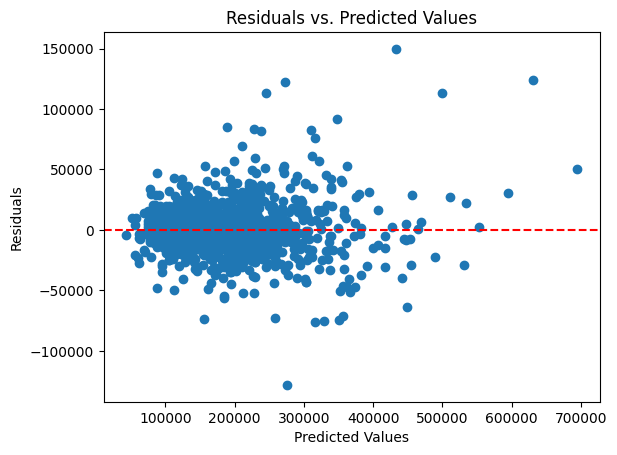

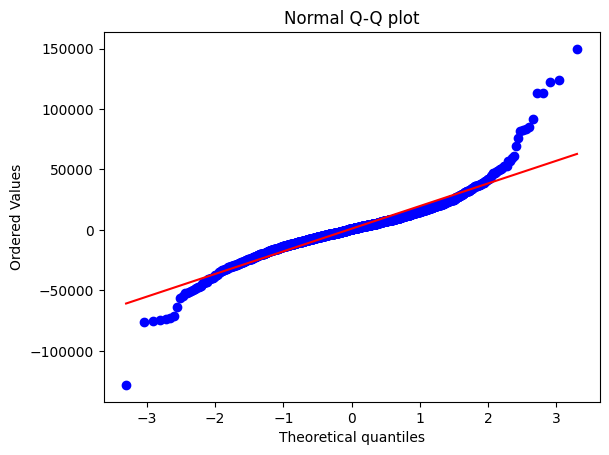

R-squared value: 0.9386655086133615
RMSE 0.10826545488515724


In [28]:
# Training the model
model = train_model_statsmodels(X_poly, y)

# Evaluating the model
X_poly = sm.add_constant(X_poly_original)  # Adding a constant to the validation data
y_pred_log =model.predict(X_poly)  # Predicted log-transformed prices
y_pred = np.expm1(y_pred_log)  # Inverse transformation
r_squared = r2_score(np.expm1(y_original), y_pred)
rmse_score = mean_squared_error(y_original, y_pred_log, squared=False)
residuals = np.expm1(y_original) - y_pred
plot_residuals(residuals, y_pred)
normality(residuals)
print("R-squared value:", r_squared)
print("RMSE", rmse_score)

In [29]:
y_pred_log

0       12.263199
1       12.149703
2       12.270931
3       12.006061
4       12.575987
          ...    
1455    12.076312
1456    12.291609
1457    12.463057
1458    11.819684
1459    11.935836
Length: 1460, dtype: float64

In [30]:
(rmse_score + rmse_average) / 2

0.12707402754678737

In [31]:
'''
weights = lasso.coef_
plt.hist(weights, bins=50, log=True)

# Identify columns with weight below 0.5
columns_to_delete = [column for column, weight in zip(list(lasso.feature_names_in_), weights) if abs(weight) <= 3e-10]

# Delete these columns from X
X_filtered = X_poly.drop(columns=columns_to_delete)
X_filtered_test = X_test.drop(columns=columns_to_delete)
X_filtered_test
'''

'\nweights = lasso.coef_\nplt.hist(weights, bins=50, log=True)\n\n# Identify columns with weight below 0.5\ncolumns_to_delete = [column for column, weight in zip(list(lasso.feature_names_in_), weights) if abs(weight) <= 3e-10]\n\n# Delete these columns from X\nX_filtered = X_poly.drop(columns=columns_to_delete)\nX_filtered_test = X_test.drop(columns=columns_to_delete)\nX_filtered_test\n'

In [32]:
'''
model = train_model_statsmodels(X_filtered, y_train)

# Evaluating the model
X_filtered = sm.add_constant(X_filtered)  # Adding a constant to the validation data
y_pred_log =model.predict(X_filtered)  # Predicted log-transformed prices
y_pred = np.expm1(y_pred_log)  # Inverse transformation
r_squared = r2_score(np.expm1(y), y_pred)
residuals = np.expm1(y) - y_pred
plot_residuals(residuals, y_pred)
normality(residuals)
print("R-squared value:", r_squared)
'''

'\nmodel = train_model_statsmodels(X_filtered, y_train)\n\n# Evaluating the model\nX_filtered = sm.add_constant(X_filtered)  # Adding a constant to the validation data\ny_pred_log =model.predict(X_filtered)  # Predicted log-transformed prices\ny_pred = np.expm1(y_pred_log)  # Inverse transformation\nr_squared = r2_score(np.expm1(y), y_pred)\nresiduals = np.expm1(y) - y_pred\nplot_residuals(residuals, y_pred)\nnormality(residuals)\nprint("R-squared value:", r_squared)\n'

In [33]:
# Predicting the housing prices for the test data
X_test = sm.add_constant(X_test)  # Adding a constant to the test data
predicted_log_prices = model.predict(X_test)  # Predicted log-transformed prices for test data
predicted_prices = np.expm1(predicted_log_prices)  # Inverse transformation for test data predictions

In [34]:
predicted_prices

0       123448.978372
1       177803.337477
2       188740.886235
3       200837.928098
4       180533.478570
            ...      
1454     95083.860121
1455     94100.598322
1456    157784.465850
1457    119941.279848
1458    221735.647124
Length: 1459, dtype: float64

In [35]:
''
# Saving the predictions
predicted_prices_df = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': predicted_prices
})
predicted_prices_df.to_csv('predicted_housing_prices_statsmodels.csv', index=False)
''

''

In [36]:
predicted_prices_df

,Id,SalePrice
0,1461,123448.978372
1,1462,177803.337477
2,1463,188740.886235
3,1464,200837.928098
4,1465,180533.478570
...,...,...
1454,2915,95083.860121
1455,2916,94100.598322
1456,2917,157784.465850
1457,2918,119941.279848


In [37]:
train_data.columns.tolist()

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice',
 'remod',
 'NeighborhoodQual',
 'NeighborhoodCond',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Grvl',
 'Street_Pave',
 'Alley_Grvl',
 'Alley_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_AllPub',
 'Utilities_NoSeWa',
 'LotConfig_Corner',
 'L

In [38]:
error = np.expm1(y) - y_pred
error = np.abs(error)
error_ascending = error.sort_values()
train_data['error'] = error
train_data.sort_values(by='error')

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Neighborhood,remod_last,error
78,79,90.0,72.0,10778.0,4.0,5.0,1968.0,1968,0.0,0,...,True,False,False,False,False,1.0,False,Sawyer,1968.0,5.100360
26,27,20.0,60.0,7200.0,5.0,7.0,1951.0,2000,0.0,234,...,True,False,False,False,False,1.0,False,NAmes,2000.0,16.868721
1064,1065,20.0,NaN,11000.0,5.0,6.0,1966.0,1966,200.0,740,...,True,False,False,False,False,1.0,False,NAmes,1966.0,48.770367
342,343,90.0,NaN,8544.0,3.0,4.0,1949.0,1950,340.0,0,...,True,False,False,False,False,1.0,False,NAmes,1950.0,58.031150
665,666,60.0,106.0,11194.0,8.0,5.0,2000.0,2000,40.0,0,...,True,False,False,False,False,1.0,False,Gilbert,2000.0,96.277846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,609,70.0,78.0,12168.0,8.0,6.0,1934.0,1998,0.0,428,...,True,False,False,True,False,0.0,False,Crawfor,1998.0,113463.956984
774,775,20.0,110.0,14226.0,8.0,5.0,2006.0,2006,375.0,0,...,False,False,False,False,False,0.0,True,NridgHt,2006.0,122404.258596
691,692,60.0,104.0,21535.0,10.0,6.0,1994.0,1995,1170.0,1455,...,True,False,False,False,False,1.0,False,NoRidge,1995.0,124323.189877
1324,1325,20.0,75.0,9986.0,8.0,5.0,2006.0,2007,428.0,0,...,False,False,False,False,False,0.0,True,Somerst,2007.0,128219.066058


In [39]:
train_merged = pd.merge(original_train, train_data[['Id', 'error']], on='Id')
train_merged

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,remod_last,error
0,1,60.0,65.0,8450.0,7.0,5.0,2003.0,2003,196.0,706,...,False,True,False,False,False,False,1.0,False,2003.0,3256.923485
1,2,20.0,80.0,9600.0,6.0,8.0,1976.0,1976,0.0,978,...,False,True,False,False,False,False,1.0,False,1976.0,7536.957780
2,3,60.0,68.0,11250.0,7.0,5.0,2001.0,2002,162.0,486,...,False,True,False,False,False,False,1.0,False,2002.0,10099.432756
3,4,70.0,60.0,9550.0,7.0,5.0,1915.0,1970,0.0,216,...,False,True,True,False,False,False,0.0,False,1970.0,23743.228187
4,5,60.0,84.0,14260.0,8.0,5.0,2000.0,2000,350.0,655,...,False,True,False,False,False,False,1.0,False,2000.0,39520.995719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60.0,62.0,7917.0,6.0,5.0,1999.0,2000,0.0,0,...,False,True,False,False,False,False,1.0,False,2000.0,660.039152
1456,1457,20.0,85.0,13175.0,6.0,6.0,1978.0,1988,119.0,790,...,False,True,False,False,False,False,1.0,False,1988.0,7859.149822
1457,1458,70.0,66.0,9042.0,7.0,9.0,1941.0,2006,0.0,275,...,False,True,False,False,False,False,1.0,False,2006.0,7896.136425
1458,1459,20.0,68.0,9717.0,5.0,6.0,1950.0,1996,0.0,49,...,False,True,False,False,False,False,1.0,False,1996.0,6224.726853


In [40]:
train_merged.sort_values(by='error')

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,remod_last,error
78,79,90.0,72.0,10778.0,4.0,5.0,1968.0,1968,0.0,0,...,False,True,False,False,False,False,1.0,False,1968.0,5.100360
26,27,20.0,60.0,7200.0,5.0,7.0,1951.0,2000,0.0,234,...,False,True,False,False,False,False,1.0,False,2000.0,16.868721
1064,1065,20.0,NaN,11000.0,5.0,6.0,1966.0,1966,200.0,740,...,False,True,False,False,False,False,1.0,False,1966.0,48.770367
342,343,90.0,NaN,8544.0,3.0,4.0,1949.0,1950,340.0,0,...,False,True,False,False,False,False,1.0,False,1950.0,58.031150
665,666,60.0,106.0,11194.0,8.0,5.0,2000.0,2000,40.0,0,...,False,True,False,False,False,False,1.0,False,2000.0,96.277846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,609,70.0,78.0,12168.0,8.0,6.0,1934.0,1998,0.0,428,...,False,True,False,False,True,False,0.0,False,1998.0,113463.956984
774,775,20.0,110.0,14226.0,8.0,5.0,2006.0,2006,375.0,0,...,False,False,False,False,False,False,0.0,True,2006.0,122404.258596
691,692,60.0,104.0,21535.0,10.0,6.0,1994.0,1995,1170.0,1455,...,False,True,False,False,False,False,1.0,False,1995.0,124323.189877
1324,1325,20.0,75.0,9986.0,8.0,5.0,2006.0,2007,428.0,0,...,False,False,False,False,False,False,0.0,True,2007.0,128219.066058


In [41]:
correlations = pd.get_dummies(train_merged).astype(np.float64).corrwith(train_merged['error'])
correlations.sort_values().tail(50)

WoodDeckSF               0.076595
YearBuilt                0.076678
Functional_Sev           0.077253
PoolQC_Gd                0.080518
LandSlope_Mod            0.087555
PoolArea                 0.090441
SaleCondition_Alloca     0.093200
OpenPorchSF              0.097439
RoofStyle_Flat           0.100057
BsmtFinType1_GLQ         0.100214
BsmtUnfSF                0.100620
RoofMatl_Tar&Grv         0.102604
LotArea                  0.110261
MasVnrType_Stone         0.111213
ExterQual_Gd             0.115574
HeatingQC                0.116212
YearRemodAdd             0.122669
remod_last               0.122669
RoofStyle_Hip            0.126604
Foundation_PConc         0.130337
LandContour_HLS          0.130626
GarageFinish_Fin         0.135016
BsmtFinSF1               0.135316
Condition2_PosN          0.141445
Neighborhood_NoRidge     0.143603
2ndFlrSF                 0.147641
FireplaceQu_Ex           0.153378
Neighborhood_NridgHt     0.157214
Neighborhood_Crawfor     0.158015
NeighborhoodQu